# Introduction: Swing Trading with application of Filters

**Filters To be applied:

1)Filter based on the liquidity (Volumne, Close Price, High and Low)

2)Hurst (close): series having 0.5 to 1 have memory

3)ADX (high, low, close): Average of last 100 values to be greater than 25, to confirm trend

**Buy or sell Decision:

1)Outperforming benchmark (S&P close and stock close)

2)Buying stocks and selling stocks

Methodolgy: Firstly the given sample would be divided into 50% group. On the First 50% sample the Filter listed above will be applied and the Filtered list will be passed through the decision functions, which are also listed above.
Then the positions will be taken for next 50% of the returns to backtest the strategy.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate
    
import matplotlib.pyplot as plt

import seaborn as sb
sb.set_style('darkgrid')
import monthly_returns_heatmap as mrh

In [2]:
import numpy as np


Getting the List of the Stocks incorporated in the S&P 500

In [51]:
import pandas as pd
from datetime import date
# Read the html into stocks dataframe
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', header =0)
stocks = pd.DataFrame(data[0])
stocks.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


Download the stocks Data using Yfinance Library

In [52]:
import yfinance as yf
# Download the stock data for all tickers as in the index of the stocks dataframe
tickers=list(stocks['Symbol'])
params=['High','Low','Open','Close','Volume']
start='2018-01-01'
end='2021-01-01'

In [157]:
data_stocks=yf.download(tickers=tickers,start=start,end=end,interval='1d',auto_adjust=True)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BRK.B: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [158]:
data_stocks.index=pd.to_datetime(data_stocks.index)

In [159]:
stocks=data_stocks[params]

Spliting the dataset in the 2 sample 

One Will be used for the analysis and another one to take positions.


In [160]:
split=int(0.5*stocks.shape[0])


In [161]:
Sample_analysis=stocks.iloc[:split]

In [162]:
Returns_analysis=stocks.iloc[split:]

Segregating the Parameters

In [163]:
columns=stocks['High'].columns
stocks_High=Sample_analysis['High']
stocks_low=Sample_analysis['Low']
stocks_close=Sample_analysis['Close']
stocks_volume=Sample_analysis['Volume']

Testing the shape : Sometimes due to bad Internet connection or  unstable downloading source NaN comes in data

In [164]:
x=stocks_close.shape
y=stocks_High.shape
z=stocks_low.shape
v=stocks_volume.shape

In [165]:
if x==y==z==v:
    print('Same Shape ')
else:
    raise ValueError("Expected Same Shape Download the data properly")

Same Shape 


# Part-1: Filtering the stocks

## Liquidity Filter

Liquidity is defined as per the below Formula:

                                             Liquidity = Log10(Numerator/Denominator)
                                             Numerator = Volume of the stock * Close price
                                            Denominator = Day’s High – Day’s Low
                                            
                                            
Rational Behind this is taken from the Definition of the Liquidity by CFA institute.

As the difference between the High and Low decreases, we have more buyers and sellers at any price,thus increasing the Liquidity of the particular Stock 

Taking the log of the values to standardize the values.


In [166]:
trading_volume=Sample_analysis['Volume']
numerator=trading_volume*stocks_close.values
denominator=stocks_High-stocks_low.values
liquidity=np.log10(numerator/denominator) 
# Reference from CFA Finance Paper

last=liquidity.mean()
sort=last.sort_values(ascending=False).dropna() # Sorting the Liquidities of the stocks to filter out the relevant stocks

#Calculating the Mean Liquidity of the Market
Long_term_mean=(liquidity.mean(numeric_only=True,skipna=True))
Cleaned_table=Long_term_mean.replace([np.inf, -np.inf], np.nan).dropna()
Long_mean_data=Cleaned_table.mean()

#### We tend to compare the liquidity calculated with specified formula against the Liquidity of the market:
    
Thus, the market Liquidity is calculated by taking the mean of the Liquidities of all the Stocks in the Market

Text(0.5, 0, 'Stocks')

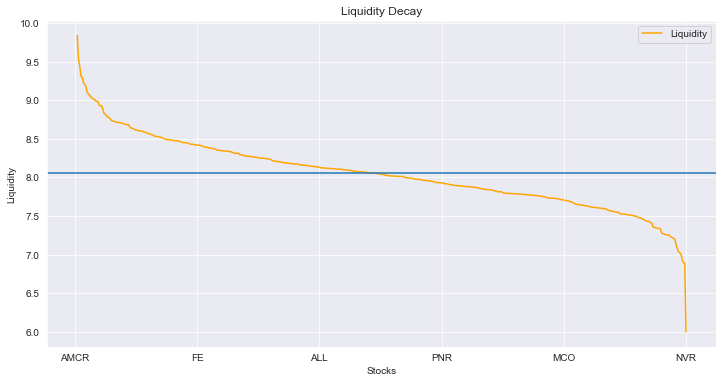

In [230]:
sort.plot(figsize=(12,6),title='Liquidity Decay',color='Orange',label='Liquidity')
plt.legend()
plt.axhline(y=Long_mean_data)# Horizontal Lines depicts the Long term Liquidity of the Market, given by Varible "Long_mean_data"
plt.ylabel("Liquidity")
plt.xlabel("Stocks") # We select the stocks which are above the blue line in the graph

Applying the condition to Filter out the stocks where Liquidity is more than the Market Liquidity

In [168]:
condition=(sort>Long_mean_data)          #Liquidity More than the average Liquidity of the Market
Stocks_list=condition[condition==1]
Stocks_list=Stocks_list.index
Stocks_list

Index(['AMCR', 'FOXA', 'AAPL', 'BAC', 'GE', 'T', 'F', 'AMD', 'MSFT', 'PFE',
       ...
       'ES', 'EIX', 'MKC', 'TT', 'LYB', 'SRE', 'NTAP', 'NUE', 'DFS', 'STT'],
      dtype='object', length=247)

### Removing Stocks with length less than 100 data points: Condition of the Hurst exponent 

Sometimes the bad connection or the unstable data source results in NaNs in the data and we cannot feed this kind of series to the Hurst Filter

So, Removing the NaNs and the dataset where the length is less than 100

In [227]:
string_frame=pd.DataFrame()
for steps in range(len(Stocks_list)):
    string=Stocks_list[steps]
    series=stocks_close[string]
    if len(series.dropna())>100:
        d=pd.Series(string)
        string_frame=string_frame.append(d,ignore_index=True)
    else:
        continue
string_frame.columns=['Companies']
Filter_companies=np.array(string_frame["Companies"])


## Hurst Exponent Filter

Install the Library :https://pypi.org/project/hurst/

Use the Hust function to calculate the exponent value directly

In [170]:
from hurst import compute_Hc


In [171]:
h_table=pd.DataFrame()

In [172]:
for Steps in range(len(Filter_companies)):
    string=Filter_companies[Steps]
    series=stocks_close[string].dropna()
    H=compute_Hc(series, kind='random_walk')
    d=pd.Series(H[0])
    h_table=h_table.append(d,ignore_index=True)
h_table.index=Filter_companies

#### Filtering out the Stocks where there is a Long term memory i.e. the value is greater than 0.5

In [173]:
hurst_table=h_table[h_table>0.5].dropna()

In [174]:
filtered_columns=hurst_table.index

In [175]:
filtered_columns

Index(['AMCR', 'AAPL', 'GE', 'F', 'AMD', 'MSFT', 'PFE', 'CSCO', 'WFC', 'CMCSA',
       ...
       'RSG', 'XLNX', 'KMB', 'ES', 'MKC', 'TT', 'LYB', 'SRE', 'DFS', 'STT'],
      dtype='object', length=156)

## ADX Filter

Install the Library: https://pypi.org/project/pandas-ta-quant/
    
Use the ADX function to calculate the ADX values

In [176]:
import pandas_ta as ta


In [177]:
final=pd.DataFrame()                     #Adx calculator 
for steps in range(len(filtered_columns)):
    tick_symbol=filtered_columns[steps]
    close=stocks_close[tick_symbol]
    High=stocks_High[tick_symbol]
    Low=stocks_low[tick_symbol]
    adx=ta.adx(High,Low,close)[['ADX_14']].dropna()
    transpose=adx.T
    final=final.append(transpose)
final.index=filtered_columns
Adx_frame=final.T


In [178]:
mean_adx=Adx_frame.tail(100).mean()

#### Filtering out the Stocks which shows the Long term Trend in their prices i.e. values greater than 25

In [179]:
condition2=mean_adx[mean_adx>25]

In [180]:
Final_Filtered_list=condition2.index

# Final List of Companies after Applying: 


### (1)Liquidity Filter :      (2)Hurst Exponent Filter :       (3)ADX Filter:


In [181]:
Final_Filtered_list

Index(['AMCR', 'AAPL', 'MSFT', 'CSCO', 'CMCSA', 'PG', 'SBUX', 'QCOM', 'NEE',
       'DIS', 'EBAY', 'MDLZ', 'MO', 'LUMN', 'NVDA', 'TJX', 'HAL', 'SO', 'PEP',
       'AES', 'KHC', 'IBM', 'PM', 'WBA', 'LLY', 'SYF', 'CSX', 'CL', 'MCD',
       'GIS', 'TGT', 'CAG', 'AFL', 'FAST', 'NWL', 'XEL', 'NXPI', 'HON', 'NRG',
       'PGR', 'PEG', 'SYY', 'EMR', 'AEP', 'EW', 'LVS', 'VTRS', 'MAS', 'CMS',
       'HWM', 'DHR', 'MOS', 'BLL', 'PLD', 'WDC', 'WM', 'MMM', 'HLT', 'HIG',
       'COST', 'ZTS', 'ALL', 'CCI', 'MMC', 'BBY', 'PAYX', 'TSN', 'DG', 'ADP',
       'AMT', 'WEC', 'XLNX', 'KMB', 'ES', 'MKC', 'TT', 'SRE', 'DFS', 'STT'],
      dtype='object')

In [182]:
List_length=len(Final_Filtered_list)
List_length

79

# Part-2: Decision To buy or Sell 

## Dowloading the S&P Data

In [183]:
sp_data=yf.download(tickers='^GSPC',start=start,end=end,interval='1d')

[*********************100%***********************]  1 of 1 completed


In [184]:
sp_data.index=pd.to_datetime(sp_data.index)

In [185]:
sp_data_returns=sp_data[['Close']].pct_change().dropna()

In [186]:
sp_cum_returns=(1+sp_data_returns).cumprod() # Wealth Index

In [231]:
Sp_sample=sp_cum_returns.iloc[:split]        #Splitting the data 

In [232]:
Sp_Final_wealth=float(Sp_sample.iloc[-3])    # Calculating the Ending Wealth of the Index

#### Calculating the Final wealth of the S&P (Time sample is same as we have used in above analysis)

In [216]:
Sp_Final_wealth

1.1028262174066064

In [191]:
stocks_sample_returns=stocks_close.pct_change()

In [198]:
l=stocks_sample_returns.dropna(how='all')
stocks_sample_cumret=(l+1).cumprod()
Filtered_cumreturns=stocks_sample_cumret[Final_Filtered_list]

In [207]:
Filtered_cumreturns
Filtered_final_wealth=Filtered_cumreturns.iloc[-1]

# Filtering out the Stocks from List we have made.

Criteria: 

    OutPerforming stocks are those whose Wealth is more than S&P
    
    UnderPerforming Stocks are those whose Wealth is less than S&P

In [220]:
Outperforming_stocks=Filtered_final_wealth[Filtered_final_wealth>Sp_Final_wealth]

In [221]:
Underperforming_stocks=Filtered_final_wealth[Filtered_final_wealth<Sp_Final_wealth]

In [222]:
list_outperforming=Outperforming_stocks.index

# OutPerforming

In [223]:
list_outperforming

Index(['AAPL', 'MSFT', 'CSCO', 'PG', 'SBUX', 'QCOM', 'NEE', 'DIS', 'MDLZ',
       'TJX', 'SO', 'PEP', 'AES', 'LLY', 'CSX', 'MCD', 'TGT', 'AFL', 'FAST',
       'XEL', 'HON', 'NRG', 'PGR', 'PEG', 'SYY', 'AEP', 'EW', 'CMS', 'DHR',
       'BLL', 'PLD', 'WM', 'HLT', 'COST', 'ZTS', 'CCI', 'MMC', 'PAYX', 'DG',
       'ADP', 'AMT', 'WEC', 'XLNX', 'KMB', 'ES', 'MKC', 'TT', 'SRE'],
      dtype='object')

In [224]:
list_underporforming=Underperforming_stocks.index

# UnderPerforming

In [225]:
list_underporforming

Index(['AMCR', 'CMCSA', 'EBAY', 'MO', 'LUMN', 'NVDA', 'HAL', 'KHC', 'IBM',
       'PM', 'WBA', 'SYF', 'CL', 'GIS', 'CAG', 'NWL', 'NXPI', 'EMR', 'LVS',
       'VTRS', 'MAS', 'HWM', 'MOS', 'WDC', 'MMM', 'HIG', 'ALL', 'BBY', 'TSN',
       'DFS', 'STT'],
      dtype='object')

# Part-3: Now, taking the Postions

#### Taking weighing Method to be Equally Weighted but GMV or MSR can also be used

In [234]:
n=len(list_outperforming)
weight=np.repeat(1/n,n)

#### Using the List of the Outperforming Stocks to take Long Positions

In [252]:
Rets=Returns_analysis['Close'][list_outperforming].pct_change().dropna()

In [288]:
Returns_series=pd.DataFrame({"Strategy":(Rets*weight).sum(axis=1)})

In [289]:
index=sp_data_returns[split:]
index.columns=['Benchmark']

In [290]:
frame=pd.concat([Returns_series,index],axis=1).dropna()


# Comparing the Wealth Index of both the Series

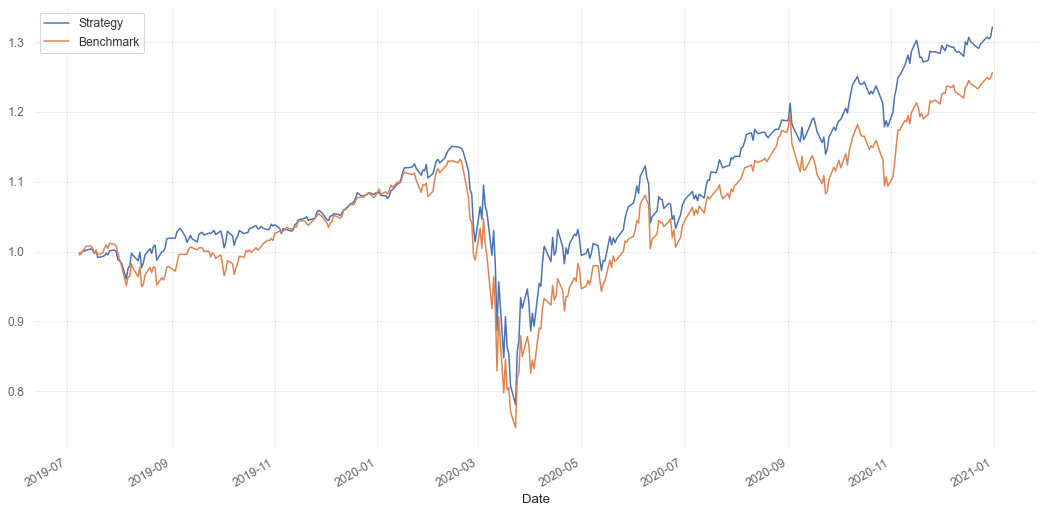

In [310]:
(1+frame).cumprod().plot(figsize=(18,9))